In [160]:
import h5py
import math
import numpy as np
import scipy.fftpack
import matplotlib.pyplot as plt
%matplotlib inline


### Reading and interpreting plane wave files
These files are the output of Quantum Espresso using pw2qmcpack, which is contained in some patches to QE shipped with QMCPACK (in the external_files/quantum_espresso directory).   These files are in HDF5 format.

In [345]:
#f = h5py.File("../LiH-gamma.pwscf.h5","r")
#f = h5py.File("../LiH-arb.pwscf.h5","r")
f = h5py.File("../../bccH/pwscf.pwscf.h5","r")

Get some basic information from the file like the version number, number of kpoints (twists), atomic positions, primitive lattice, etc.

In [346]:
version = f.get('application/version')
print 'version = ',version[:]
number_of_kpoints = f.get('electrons/number_of_kpoints')
print 'number of kpoints = ',number_of_kpoints[0]
number_of_electrons = f.get('electrons/number_of_electrons')
print 'number of electrons = ',number_of_electrons[0]

version =  [4 0 4]
number of kpoints =  1
number of electrons =  1


In [347]:
atom_pos = f.get('atoms/positions')
print atom_pos[:]

[[ 0.          0.          0.        ]
 [ 1.88972613  1.88972613  1.88972614]]


In [348]:
prim_vectors = f.get('supercell/primitive_vectors')
print prim_vectors[:]

[[ 3.77945227  0.          0.        ]
 [ 0.          3.77945227  0.        ]
 [ 0.          0.          3.77945227]]


In [349]:
# Reciprocal lattice vectors
def get_kspace_basis(basis):
    # Volume factor for reciprocal lattice
    a1, a2, a3 = basis
    vol = a1.dot(np.cross(a2, a3))

    pre = 2*math.pi
    #pre = 1.0
    b1 = pre*np.cross(a2, a3)/vol
    b2 = pre*np.cross(a3, a1)/vol
    b3 = pre*np.cross(a1, a2)/vol
    return [b1, b2, b3]


In [350]:
kbasis = get_kspace_basis(prim_vectors)
print kbasis

[array([ 1.66245923,  0.        ,  0.        ]), array([ 0.        ,  1.66245923,  0.        ]), array([ 0.        ,  0.        ,  1.66245923])]


### Information about first kpoint

In [351]:
kpoint = f.get('electrons/kpoint_0/reduced_k')
print kpoint[:]

[ 0.  0.  0.]


In [352]:
gvectors = f.get('electrons/kpoint_0/gvectors')
print gvectors[0:10,:]

[[ 0  0  0]
 [-1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]
 [ 0  0  1]
 [ 0  1  0]
 [ 1  0  0]
 [-1 -1  0]
 [-1  0 -1]
 [-1  0  1]]


In [353]:
pw_coeffs = f.get('electrons/kpoint_0/spin_0/state_0/psi_g')
print pw_coeffs.shape
print pw_coeffs[0:10,:]

(10131, 2)
[[ -5.45537362e-01  -8.22710028e-01]
 [  2.19636552e-07   2.54362828e-07]
 [ -2.34132028e-07  -2.70735662e-07]
 [  6.41080905e-09  -4.31852687e-08]
 [  9.13308207e-09   2.14367402e-08]
 [ -1.52422857e-07  -3.40232563e-07]
 [  1.99970200e-07   3.42144939e-07]
 [ -2.40488969e-02  -3.62677643e-02]
 [ -2.40484681e-02  -3.62683106e-02]
 [ -2.40485568e-02  -3.62684510e-02]]


In [354]:
# Compute the orbital value at one point in real-space 
def compute_psi(gvectors, kbasis, coeff, twist, r):
    kp = kbasis[0]*twist[0] + kbasis[1]*twist[1] + kbasis[2]*twist[2]
    total_r = 0.0
    total_i = 0.0
    for idx in range(len(gvectors)):
        G = gvectors[idx]
        c = coeff[idx]
        q = kbasis[0]*G[0] + kbasis[1]*G[1] + kbasis[2]*G[2] + kp
        qr = np.dot(q,r)
        cosqr = math.cos(qr)
        sinqr = math.sin(qr)
        total_r += c[0] * cosqr - c[1] * sinqr
        total_i += c[0] * sinqr + c[1] * cosqr
    #print 'total = ',total_r, total_i
    return complex(total_r, total_i)
        

In [355]:
# Test it out at one point.
r = np.array([0.0, 0.0, 0.0])
compute_psi(gvectors, kbasis, pw_coeffs, kpoint, r)

(-1.2473558997965475-1.8810989347639937j)

In [356]:
# Compute a range of values
psi_vals = []
rvals = []
nstep = 10
cell_width = prim_vectors[0,0]
step = cell_width/nstep
for i in range(nstep+1):
    r1 = step*i
    rvals.append(r1)
    r = np.array([r1, 0.0, 0.0])
    pv = compute_psi(gvectors, kbasis, pw_coeffs, kpoint, r)
    print r1, pv
    psi_vals.append(pv)
    

0.0 (-1.2473558998-1.88109893476j)
0.377945227 (-0.929597357312-1.40190833677j)
0.755890454 (-0.696384092802-1.05020325398j)
1.133835681 (-0.565502765705-0.852821080807j)
1.511780908 (-0.50068864386-0.755074644961j)
1.889726135 (-0.481108761722-0.725544232838j)
2.267671362 (-0.500689298486-0.755069711751j)
2.645616589 (-0.565504903026-0.852813337015j)
3.023561816 (-0.696387605983-1.05019442729j)
3.401507043 (-0.929604497255-1.40190243987j)
3.77945227 (-1.2473558998-1.88109893476j)


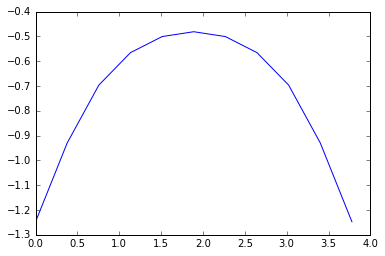

In [376]:
plt.plot(rvals, [p.real for p in psi_vals])

### Conversion to splines
Use FFT to convert to a grid in real-space

In [365]:
# Find the mesh size
# See EinsplineSetBuilder::ReadGvectors_ESHDF in QMCWavefunctions/EinsplineSetBuilderReadBands_ESHDF.cpp
#  Mesh sizes taken from QMCPACK output.
# BCC H
#meshsize = (52, 52, 52)
# LiH
#meshsize = (68, 68, 68)
MeshFactor = 1.0

max_g = np.zeros(3)
for g in gvectors:
    max_g = np.maximum(max_g, np.abs(g))
    
print 'Maximum G = ',max_g
meshsize = np.ceil(4*max_g*MeshFactor).astype(np.int)
print 'mesh size = ',meshsize

# Plus some more code for mesh sizes larger than 128 than restricts
# sizes to certain allowed values (more efficient FFT?)

Maximum G =  [ 13.  13.  13.]
mesh size =  [52 52 52]


In [367]:
# Place points in the box at the right G-vector
# see unpack4fftw in QMCWavefunctions/einspline_helper.h

fftbox = np.zeros(meshsize, dtype=np.complex_)
for c, g in zip(pw_coeffs, gvectors):
    idxs = [(g[i] + meshsize[i])%meshsize[i] for i in range(3)]
    fftbox[idxs[0], idxs[1], idxs[2]] = complex(c[0], c[1])

In [368]:
realbox = scipy.fftpack.fftn(fftbox)

In [369]:
fftvals = np.array([a.real for a in realbox[0:meshsize[0],0,0]])
fftvals

array([-1.2473559 , -1.22008295, -1.15236579, -1.07309496, -1.00191792,
       -0.94101435, -0.88549114, -0.83388847, -0.78771675, -0.74697517,
       -0.71017254, -0.67678414, -0.64716998, -0.62103659, -0.5976146 ,
       -0.57672851, -0.55855773, -0.54281754, -0.52901007, -0.5170925 ,
       -0.50723304, -0.49920761, -0.49258584, -0.48731555, -0.48366931,
       -0.48169915, -0.48110876, -0.481699  , -0.48366907, -0.48731526,
       -0.49258544, -0.499207  , -0.50723218, -0.51709136, -0.52900861,
       -0.54281573, -0.55855566, -0.5767263 , -0.59761229, -0.6210341 ,
       -0.64716718, -0.67678092, -0.71016881, -0.7469708 , -0.78771159,
       -0.83388244, -0.88548438, -0.94100715, -1.00191067, -1.07308822,
       -1.15236039, -1.22007989])

In [371]:
xstep = prim_vectors[0][0]/meshsize[0]
xvals = [xstep * i for i in range(meshsize[0])]

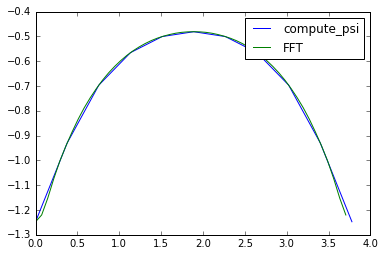

In [372]:
# Compare results of FFT and the compute_psi function
# They don't line up completely because they are on different real-space grids
line1 = plt.plot(rvals, [p.real for p in psi_vals], label="compute_psi")
line2 = plt.plot(xvals, fftvals, label="FFT")
plt.legend()

### Further processing
For the conversion to splines, there is a further orbital rotation that keeps the overall real and imaginary parts away from zero (why?).
Also the twist (kpoint) factor of $\exp(ikr)$ is applied.

See fix_phase_rotate_c2r in QMCWavefunctions/einspline_helper.h

In [373]:
realbox_kr = np.empty_like(realbox)
for ix in range(meshsize[0]):
    for iy in range(meshsize[1]):
        for iz in range(meshsize[2]):
            tx = kpoint[0]*ix/meshsize[0]
            ty = kpoint[1]*iy/meshsize[1]
            tz = kpoint[2]*iz/meshsize[2]
            tt = -2*np.pi*(tx+ty+tz)
            cos_tt = math.cos(tt)
            sin_tt = math.sin(tt)
            r = realbox[ix, iy, iz]
            realbox_kr[ix,iy,iz] = r*complex(cos_tt, sin_tt)
rNorm = 0.0
iNorm = 0.0
ii = 0
for val in np.nditer(realbox_kr):
#for val in psi_vals:
    rNorm += val.real*val.real
    iNorm += val.imag*val.imag
    ii += 1
print 'real norm, imaginary norm',rNorm,iNorm
arg = math.atan2(iNorm, rNorm)
print 'angle (degrees)',math.degrees(arg)
ang = np.pi/8 - 0.5*arg
sin_ang = math.sin(ang)
cos_ang = math.cos(ang)
rot_psi_vals = []
for val in psi_vals:
    rot = val.real*cos_ang - val.imag*sin_ang
    rot_psi_vals.append(rot)

real norm, imaginary norm 42943.1323961 97664.8676039
angle (degrees) 66.2649618713


In [374]:
# These values should be comparable to the output of the spline orbitals
rot_psi_vals

[-1.5730187632542054,
 -1.1723010853354936,
 -0.8781992869387913,
 -0.713146375364895,
 -0.6314100002655509,
 -0.6067176734849947,
 -0.631409733432758,
 -0.7131470471948752,
 -0.8782011112010332,
 -1.1723070146627808,
 -1.5730187632542059]

In [375]:
# These are on a different grid than the values above
fft_rot_vals = []
for val in realbox_kr[:,0,0]:
    rot = val.real*cos_ang - val.imag*sin_ang
    fft_rot_vals.append(rot)
fft_rot_vals[0:10]

[-1.573018763254205,
 -1.538624806835367,
 -1.4532275897161404,
 -1.3532604157255745,
 -1.2635002485303946,
 -1.186695787894654,
 -1.1166764197945607,
 -1.051601183814924,
 -0.99337482620619033,
 -0.94199628223062204]